In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import time
import datetime as dt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import wordcloud
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc, recall_score, precision_score, classification_report
from sklearn.utils import shuffle

## Retreive Data

We retrieved "The Onion" and "Not The Onion" data from November 2018 to November 2020.  In the past 104 weeks, we were able to get around 5,200 "The Onion" and 9,600 "Not the Onion" titles.

In [9]:
def getPushshiftData(after, before, sub):
    url = ('https://api.pushshift.io/reddit/search/submission/?size=100&after='+
           str(after)+'&before='+str(before)+'&subreddit='+str(sub)+'&sort_type=score'+'&sort=desc')
    print(url)
    status_code = 0
    while status_code != 200:
        r = requests.get(url)
        print(r.status_code)
        status_code = r.status_code
    data = r.json()
        
    return data['data']

def getTitles(subreddit, dates):
    titles_new = []
    titles = []

    for i in range(len(dates)-1):
        # Setting up dates
        after  = dates[i]
        before = dates[i+1]

        # Getting subreddit data between the dates after and before from r/NotTheOnion
        data = getPushshiftData(after,before,subreddit)

        # Extracting just the title
        titles_new = [post['title'] for post in data]

        # Appending new data on
        titles = titles + titles_new
        
        if (i-1) % 4 == 0:
            print(len(dates) - i, " urls to go")

    # A few posts were extracted twice, set gets rid of duplicates
    titles = list(set(titles))
    return titles

### Check for Top 100 posts Each Week of the Prior 2 Year

In [10]:
dates = pd.Series(pd.date_range(end=dt.datetime.today().date(), periods=104, freq='W', normalize=True))
epoch = list(dates.apply(dt.datetime.timestamp).astype('int64').values)

### Retrieve Data and Save to CSV for Future

In [16]:
not_onion = getTitles('nottheonion', epoch)

print('Saving {0:d} headlines from r/nottheonion...'.format(len(not_onion)))

not_onion = pd.DataFrame(not_onion, columns=['title'])
not_onion.to_csv('not_onion_final.csv')

In [ ]:
onion = getTitles('theonion', epoch)

print('Saving {0:d} headlines from r/theonion...'.format(len(onion)))

onion = pd.DataFrame(onion, columns=['title'])
onion.to_csv('onion_final.csv')

-----------------------------------------------------------

## Data Cleaning

After retrieving the data, we created word clouds to visualize titles and then merged them to one single dataframe. Further, we removed capitalization, punctuation, and a few specific words (like "Onion") to not bias the dataset. Last the stopwords were removed and every word was reduced to its stem word.

In [2]:
# read in files and add label column to identify
onion = pd.read_csv('onion_final.csv',  index_col=[0])
not_onion = pd.read_csv('not_onion_final.csv',  index_col=[0])

onion['label'] = 1
not_onion['label'] = 0

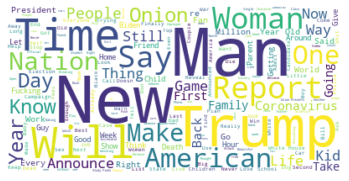

In [3]:
# join the elements together with a space between them
onion_title = ' '.join(onion['title'])
onion_title = onion_title.replace('onion', '')

# make the word cloud object
cloud = wordcloud.WordCloud(background_color='white').generate(onion_title)

#plot it
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

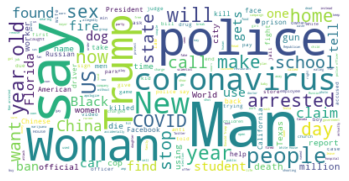

In [4]:
# join the elements together with a space between them
no_title = ' '.join(not_onion['title'])

# make the word cloud object
cloud = wordcloud.WordCloud(background_color='white').generate(no_title)

#plot it
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [5]:
# merge the two files in one
data = pd.concat([onion, not_onion], ignore_index=True)

data.head()

,title,label
0,Parenting Expert Has Nerve To Tell You How To ...,1
1,She’s Had Too Many Chances: 6 Reasons Why We S...,1
2,Heartwarming: Lionel Richie And Chewbacca Mom ...,1
3,Bored Scientists Now Just Sticking Random Thin...,1
4,Grocery Store Bar Actually Has Great Little Ha...,1


In [6]:
# select title for the classifier
title = data[['title', 'label']].copy()

# feature engineering idea provided by Paul's Supervised Tweets File
# including lower case, remove words that may give hint to true label, and merge covid-related into same format
# also removed stop words and used PorterStemmer
title.loc[:, 'title'] =title.loc[:, 'title'].str.lower()
title.loc[:, 'title'] = title.loc[:, 'title'].str.replace('onion', '')
title.loc[:, 'title'] = title.loc[:, 'title'].str.replace('topical', '')
title.loc[:, 'title'] = title.loc[:, 'title'].str.replace('present', '')
title.loc[:, 'title'] = title.loc[:, 'title'].str.replace('ep(isode)?', '')
title.loc[:, 'title'] = title.loc[:, 'title'].str.replace('[,.!\?:\'\"‘’“”#]', '')
title.loc[:, 'title'] = title.loc[:, 'title'].str.replace('(corona virus)|(coronavirus)|(covid)|(covid 19)', 'covid')
title['title'] = title['title'].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))

stop = stopwords.words('english')
title['title'] = title['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

st = PorterStemmer()
title['title'] = title['title'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

# removed duplicated titles
title = title[title.duplicated(subset=['title']) == False].reset_index()[['title', 'label']]
title.head()

,title,label
0,parent expert nerv tell rais goddamn kid,1
1,she mani chanc reason shouldnt give grandma wh...,1
2,heartwarm lionel richi chewbacca mom buri hatc...,1
3,bore scientist stick random thing larg hadron ...,1
4,groceri store bar actual great littl happi hou...,1


In [26]:
# Quick glance at different titles
print("【Not-Onion Titles】")
title['len'] = [len(x) for x in title['title'].str.split()]
for x in title[(title['label'] == 0) & (title['len'] <= 7)]['title'][100:120]:
    print(x)

【Not-Onion Titles】
kill injur quebec citi man wield sword
isol tribe continent us get broadband
florida senat approv bill allow arm teacher
dubai nissan corvett ambul
man jail give girlfriend wet willi
hong kong woman sentenc assault cop breast
kid challeng trump go vegan donat veteran
nixon foundat distanc roger stone
peopl throw chees babi chees challeng
campaign lega seri introduc three portrait monkey
mani see empathi requir much mental effort
drop price weed green parti say
famili dollar announc plan sell alcohol
outbreak contact trace centr
trump attack mail vote cast mail ballot
nurs offer supermarket discount persuad stay nh
nurs kind hero
jail kt kitchen hand slave curri hous
new sourc covid spread us parti
entrreneur make mask


-----------------------------------------------------------

## Building the Classifier

To build the classifier, we tried the Count Vectorizer and Tf-Idf Vectorizer with multiple models, including Naive Bayes, Support Vector Machine, Random Forest, etc. 
We reported AUC values as well as the classfication report result for each model.

In [7]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(title['title'], title['label'], random_state=0)

### Using Count Vectorizer and Naive Bayes

In [8]:
# using uni-gram and finding the best paratmeter with GridSearch
parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}

vectorizer = CountVectorizer(stop_words='english', min_df=5).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)
classfier = MultinomialNB()

clf = GridSearchCV(classfier, parameters, scoring='recall').fit(X_train_vectorized, y_train)

clf.best_params_

{'alpha': 1}

In [9]:
classfier = MultinomialNB(alpha=1).fit(X_train_vectorized, y_train)
predictions = classfier.predict(vectorizer.transform(X_test))

print("AUC:", roc_auc_score(y_test, predictions), '\n')
print (classification_report(y_test, predictions, digits=4))

AUC: 0.7591061762431497 

              precision    recall  f1-score   support

           0     0.8364    0.8464    0.8414      2428
           1     0.6881    0.6718    0.6799      1225

    accuracy                         0.7878      3653
   macro avg     0.7623    0.7591    0.7606      3653
weighted avg     0.7867    0.7878    0.7872      3653



In [10]:
# using uni, bi, tri-gram and finding the best paratmeter with GridSearch

parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}

vectorizer = CountVectorizer(stop_words='english', min_df=7, ngram_range=(1, 3)).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)
classfier = MultinomialNB()

clf = GridSearchCV(classfier, parameters, scoring='recall').fit(X_train_vectorized, y_train)

clf.best_params_

{'alpha': 1}

In [12]:
vectorizer = CountVectorizer(stop_words='english', min_df=7, ngram_range=(1, 3)).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)
classfier = MultinomialNB(alpha=1).fit(X_train_vectorized, y_train)
predictions = classfier.predict(vectorizer.transform(X_test))

print("AUC:", roc_auc_score(y_test, predictions), '\n')
print (classification_report(y_test, predictions, digits=4))

AUC: 0.7631323336583397 

              precision    recall  f1-score   support

           0     0.8430    0.8340    0.8385      2428
           1     0.6779    0.6922    0.6850      1225

    accuracy                         0.7865      3653
   macro avg     0.7605    0.7631    0.7617      3653
weighted avg     0.7877    0.7865    0.7870      3653



### Using Tfidf Vectorizer and Naive Bayes

In [32]:
# Finding the best paratmeter with GridSearch
parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}

vect = TfidfVectorizer(stop_words='english', min_df=5).fit(X_train)
X_train_vectorized = vect.transform(X_train)
classfier = MultinomialNB().fit(X_train_vectorized, y_train)

clf = GridSearchCV(classfier, parameters, scoring='recall').fit(X_train_vectorized, y_train)

clf.best_params_

{'alpha': 0.1}

In [33]:
classfier = MultinomialNB(alpha=0.01).fit(X_train_vectorized, y_train)
predictions = classfier.predict(vect.transform(X_test))

print("AUC:", roc_auc_score(y_test, predictions), '\n')
print (classification_report(y_test, predictions, digits=4))

AUC: 0.7276972733080053 

              precision    recall  f1-score   support

           0     0.8012    0.8962    0.8460      2428
           1     0.7311    0.5592    0.6337      1225

    accuracy                         0.7832      3653
   macro avg     0.7661    0.7277    0.7399      3653
weighted avg     0.7777    0.7832    0.7748      3653



In [34]:
# Using n-gram and finding the best paratmeter with GridSearch

vect = TfidfVectorizer(stop_words='english', min_df=5, ngram_range=(1,4)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
classfier = MultinomialNB(alpha=0.1).fit(X_train_vectorized, y_train)
predictions = classfier.predict(vect.transform(X_test))

print("AUC:", roc_auc_score(y_test, predictions), '\n')
print (classification_report(y_test, predictions, digits=4))

AUC: 0.7354338836028644 

              precision    recall  f1-score   support

           0     0.8076    0.8921    0.8477      2428
           1     0.7302    0.5788    0.6457      1225

    accuracy                         0.7870      3653
   macro avg     0.7689    0.7354    0.7467      3653
weighted avg     0.7816    0.7870    0.7800      3653



### Using Tfidf Vectorizer and SVM

In [35]:
# Finding the best paratmeter with GridSearch

parameters = {'C': [0.01, 0.1, 1, 10, 100]}
                                      
vect = TfidfVectorizer(stop_words='english', min_df=5).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

svc_model = SVC().fit(X_train_vectorized, y_train)

clf = GridSearchCV(svc_model, parameters, scoring='recall').fit(X_train_vectorized, y_train)

clf.best_params_

{'C': 10}

In [36]:
svc_model = SVC(C = 10).fit(X_train_vectorized, y_train)
predictions = svc_model.predict(X_test_vectorized)

print("AUC:", roc_auc_score(y_test, predictions), '\n')
print (classification_report(y_test, predictions, digits=4))

AUC: 0.7545768752311468 

              precision    recall  f1-score   support

           0     0.8240    0.8830    0.8525      2428
           1     0.7298    0.6261    0.6740      1225

    accuracy                         0.7969      3653
   macro avg     0.7769    0.7546    0.7632      3653
weighted avg     0.7924    0.7969    0.7926      3653



### Using Tfidf Vectorizer and Random Forest

In [37]:
# Finding the best paratmeter with GridSearch

parameters = {'max_depth': [5, 7, 9],
                           'min_samples_split': [3, 5, 7],
                           'min_samples_leaf': [1, 3, 5]}
                                      
vectorizer = TfidfVectorizer(stop_words='english', min_df=5).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)

classfier = RandomForestClassifier().fit(X_train_vectorized, y_train)

clf = GridSearchCV(classfier, parameters, scoring='recall').fit(X_train_vectorized, y_train)

clf.best_params_

{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 7}

In [38]:
classfier = RandomForestClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=3).fit(X_train_vectorized, y_train)
predictions = classfier.predict(vectorizer.transform(X_test))

print("AUC:", roc_auc_score(y_test, predictions), '\n')
print (classification_report(y_test, predictions, digits=4))

AUC: 0.5 

              precision    recall  f1-score   support

           0     0.6647    1.0000    0.7986      2428
           1     0.0000    0.0000    0.0000      1225

    accuracy                         0.6647      3653
   macro avg     0.3323    0.5000    0.3993      3653
weighted avg     0.4418    0.6647    0.5308      3653



/opt/miniconda3/envs/page/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------------------

## Model Performance

Since the first combination (Count Vectorizer and Naive Bayes with n-grams) provides the better result, we created plots to visualize the results.

### ROC Curve

AUC: 0.7631323336583397 

              precision    recall  f1-score   support

           0     0.8430    0.8340    0.8385      2428
           1     0.6779    0.6922    0.6850      1225

    accuracy                         0.7865      3653
   macro avg     0.7605    0.7631    0.7617      3653
weighted avg     0.7877    0.7865    0.7870      3653



C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


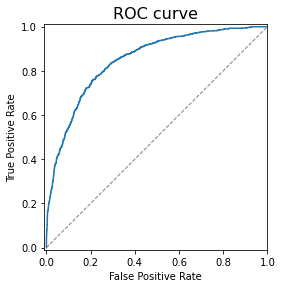

In [14]:
# re-create the train-test split and vectorizer to ensure correctness
X_train, X_test, y_train, y_test = train_test_split(title['title'], title['label'], random_state=0)

vectorizer = CountVectorizer(stop_words='english', min_df=7, ngram_range=(1, 4)).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# re-build the best model
classfier = MultinomialNB(alpha=1).fit(X_train_vectorized, y_train)
predictions = classfier.predict(vectorizer.transform(X_test))

# print out results
print("AUC:", roc_auc_score(y_test, predictions), '\n')
print (classification_report(y_test, predictions, digits=4))

# plot ROC curve using code shared by Paul
y_score = classfier.predict_proba(X_test_vectorized)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 5))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=1.5, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC curve', fontsize=16)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### What are the most common words in onion titles?

In [15]:
# filter out the onion news
fake_title = title[title['label']==1]['title']
fake_transformed = vectorizer.transform(fake_title)

# transform sparse matrix to dataframe and retrieve the largest 10
df = pd.DataFrame.sparse.from_spmatrix(fake_transformed, columns=vectorizer.get_feature_names())
df.sum(axis=0).nlargest(10)

new        368
man        323
trump      320
time       178
announc    158
rort       154
nation     150
like       149
say        145
make       141
dtype: int64

### What are the most common words in Not Onion titles?

In [16]:
# filter out not the onion news
fake_title = title[title['label']==0]['title']
fake_transformed = vectorizer.transform(fake_title)

# transform sparse matrix to dataframe and retrieve the largest 10
df = pd.DataFrame.sparse.from_spmatrix(fake_transformed, columns=vectorizer.get_feature_names())
df.sum(axis=0).nlargest(10)

man       990
say       867
polic     635
woman     396
covid     391
trump     366
new       326
use       303
arrest    295
peopl     255
dtype: int64

### What are the most important features that helped prediction?

In [17]:
# creating the dataframe that contains feature name as index and coefficient 
feature = pd.DataFrame(classfier.coef_).T
feature.set_index([vectorizer.get_feature_names()], inplace=True)
feature.nlargest(10, columns=0)

,0
new,-4.604496
man,-4.737015
trump,-4.741072
time,-5.311929
announc,-5.402216
nation,-5.475719
say,-5.492813
rort,-5.501471
like,-5.536873
make,-5.592443


In [19]:
# find out most important feature for differnt length of feature name
feature['len'] = [len(x) for x in feature.index.str.split()]
feature[feature['len'] > 2].nlargest(10, columns=0)

,0,len
ruth bader ginsburg,-8.166962,3
new york time,-8.454644,3
new york citi,-8.860109,3
test posit covid,-9.553256,3
wear face mask,-9.553256,3
daili flash post,-10.246403,3
daili flash post hopperj,-10.246403,4
flash post hopperj,-10.246403,3
gender reveal parti,-10.246403,3


-----------------------------------------------------------

## Testing using external data

Using data from [this Kaggle dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset), we tried to understand if our model worked well on external data.

In [20]:
fake = pd.read_csv('Fake.csv')
fake = fake[['title']]
fake['label'] = 1

true = pd.read_csv('True.csv')
true = true[['title']]
true['label'] = 0

test = pd.concat([true, fake], ignore_index=True)
test.shape

(44898, 2)

In [23]:
# sample the data to ensure randomness
test = shuffle(test, random_state=1)
test_data = test.sample(1000, random_state=0).reset_index()[['title', 'label']]

# redo the pre-processing
test_data.loc[:, 'title'] =test_data.loc[:, 'title'].str.lower()
test_data.loc[:, 'title'] = test_data.loc[:, 'title'].str.replace('onion', '')
test_data.loc[:, 'title'] = test_data.loc[:, 'title'].str.replace('topical', '')
test_data.loc[:, 'title'] = test_data.loc[:, 'title'].str.replace('present', '')
test_data.loc[:, 'title'] = test_data.loc[:, 'title'].str.replace('ep(isode)?', '')
test_data.loc[:, 'title'] = test_data.loc[:, 'title'].str.replace('[,.!\?:\'\"‘’“”#]', '')
test_data.loc[:, 'title'] = test_data.loc[:, 'title'].str.replace('(corona virus)|(coronavirus)|(covid)|(covid 19)', 'covid')

test_data['title'] = test_data['title'].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))

stop = stopwords.words('english')
test_data['title'] = test_data['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

st = PorterStemmer()
test_data['title'] =test_data['title'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

test_data.head(10)

,title,label
0,hurrican irma kill five swe island saint martin,0
1,xi power parad china parti congress loom,0
2,trump say obama presid worst thing ever happen...,1
3,watch angri teacher play mock assassin trump die,1
4,fox news voic reason destroy politic russian h...,1
5,hillari announc defens kill babi ke babi aliv ...,1
6,exclus tillerson plan skip nato meet visit rus...,0
7,un welcom obama guantanamo plan call due process,0
8,friday new york daili news cover perfectli ill...,1
9,trump admit knew flynn lie fbi ask comey drop ...,1


In [34]:
test_data.loc[test_data['len'] < 7][30:40]

,title,label,len
241,chess feder say israel exclud match,0,6
242,one spot democrat parti nutshel,1,5
247,malaysia arrest eight suspect terror link,0,6
249,serbia pension ralli govern auster measur,0,6
251,polit committe recommend clinton endors,0,5
252,obama undermin slash nuclear,1,4
277,factbox trump twitter network,0,4
302,rbg blast rublican crippl suprem court,1,6
313,here conserv silent cop killer data,1,6
315,break american hostag taken houthi yemen,1,6


In [22]:
# transform the test data and use the model to predict the result
test_vectorized = vectorizer.transform(test_data['title'])
predictions = classfier.predict(test_vectorized)

print("AUC:", roc_auc_score(test_data['label'], predictions), '\n')
print (classification_report(test_data['label'], predictions, digits=4))

AUC: 0.6475134719634255 

              precision    recall  f1-score   support

           0     0.5892    0.7310    0.6525       461
           1     0.7103    0.5640    0.6287       539

    accuracy                         0.6410      1000
   macro avg     0.6497    0.6475    0.6406      1000
weighted avg     0.6544    0.6410    0.6397      1000



-----------------------------------------------------------

## Other References

https://www.thesocialhistorian.com/fake-news/

https://s3.amazonaws.com/media.mediapost.com/uploads/EconomicCostOfFakeNews.pdf

https://scholarworks.umt.edu/cgi/viewcontent.cgi?article=9786&context=etd

http://www3.weforum.org/docs/WEF_GRR18_Report.pdf

https://www.cits.ucsb.edu/fake-news/brief-history

https://www.washingtonpost.com/outlook/fake-news-threatens-our-businesses-not-just-our-politics/2019
